# Create geojson file with the caucus supersite borders
    
- read Judi's supersite precinct file
- group precincts by supersite
- create a border file around the each supersite precincts
- Save files in geojson format ready to be used directly in an online map
    - GeoJSON output files for Leaflet


- NOTE: need to update precinct to Supersite geojson every time a Supersite/precinct list is modified 
    - e.g. move precincts 814 and 823 from Frasier to Manhatten

- Started: January 7, 2024
- Updated: 

### Input Files

- Judi Bodinger's Caucus Supersite file with precinct column
    - supersiteDB/data/Draft Supersites-judi-20240106.xlsx

        - Supersite
        - Pct #'s
        ...

### Output Files
- ss_pct_geom.geojson file 
  - supersite_pct.geojson
  - ss_name
  - geometry - border around all precincts


In [1]:
import pandas as pd
import geopandas as gpd
import fiona
# import numpy as np

## Create sspct - dataframe of supersites with list of precincts in a column  

- sspct - dataframe of 2024 supersites  

        - Supersite
        - Region	
        - (# of Reg Dems)	
        - Forecast of  Attendees	
        - (# of Pct's)	
        - Pct #'s
        - (# of Chairs)	
        - Chair Name
        - Chair2 Name	
        - Chair3 Name	
        - chair 4 Name	
        - Chair 5 Name


In [2]:
# Read current supersite list
sspct = pd.read_excel('data/Draft Supersites-judi-20240106.xlsx', sheet_name='Draft 1-6', skiprows=3)
sspct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Supersite               20 non-null     object 
 1   Region                  20 non-null     object 
 2   # of Reg Dems           20 non-null     int64  
 3   Forecast of  Attendees  20 non-null     float64
 4   # of Pct's              20 non-null     int64  
 5   Pct #'s                 20 non-null     object 
 6   # of Chairs             20 non-null     int64  
 7   Chair Name              20 non-null     object 
 8   Chair2 Name             13 non-null     object 
 9   Chair3 Name             8 non-null      object 
 10  chair 4 Name            2 non-null      object 
 11  Chair 5 Name            1 non-null      object 
dtypes: float64(1), int64(3), object(8)
memory usage: 2.0+ KB


In [3]:
cols = sspct.columns
# cols = ['Supersite', 'Region', '# of Reg Dems', 'Forecast of  Attendees',
#        '# of Pct's', 'Pct #'s', '# of Chairs', 'Chair Name', 'Chair2 Name',
#        'Chair3 Name', 'chair 4 Name', 'Chair 5 Name']

In [4]:
sspct["Pct #'s"]

0      810,817,818,820,821,828,829,831,832,833,,,,,,,,,
1               822,823,824,825,826,827,910,,,,,,,,,,,,
2     803,804,805,806,807,808,811,812,813,814,815,81...
3                                 913,,,,,,,,,,,,,,,,,,
4     4,500,501,834,835,836,837,838,839,840,841,842,...
5     830,843,844,845,846,847,850,851,852,853,854,85...
6         400,401,402,403,404,405,406,407,408,,,,,,,,,,
7     503,504,505,506,507,508,509,510,800,801,802,80...
8     300,301,302,303,304,305,306,307,308,309,310,31...
9     606,607,608,609,610,611,614,615,616,624,625,63...
10           600,601,602,603,604,605,612,613,,,,,,,,,,,
11    626,627,628,629,643,644,645,646,617,632,641,64...
12    2,618,619,620,621,622,623,633,634,635,636,637,...
13    200,201,202,203,204,205,206,207,208,209,210,21...
14                                914,,,,,,,,,,,,,,,,,,
15                                909,,,,,,,,,,,,,,,,,,
16                    700,701,702,915,916,,,,,,,,,,,,,,
17                 901,902,903,904,905,907,,,,,,

### Create Supersite borders and save to file

In [5]:
# get string of precincts in each supersite
sspcts = sspct["Pct #'s"].tolist()

# for each supersite, transform precinct strings to list of precincts
sspctlist = [pct.rstrip(',').split(',') for pct in sspcts]
sspctlist[:2]

[['810', '817', '818', '820', '821', '828', '829', '831', '832', '833'],
 ['822', '823', '824', '825', '826', '827', '910']]

In [6]:
# add pctlist column to sspct dataframe
sspct['pctlist'] = sspctlist
sspct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Supersite               20 non-null     object 
 1   Region                  20 non-null     object 
 2   # of Reg Dems           20 non-null     int64  
 3   Forecast of  Attendees  20 non-null     float64
 4   # of Pct's              20 non-null     int64  
 5   Pct #'s                 20 non-null     object 
 6   # of Chairs             20 non-null     int64  
 7   Chair Name              20 non-null     object 
 8   Chair2 Name             13 non-null     object 
 9   Chair3 Name             8 non-null      object 
 10  chair 4 Name            2 non-null      object 
 11  Chair 5 Name            1 non-null      object 
 12  pctlist                 20 non-null     object 
dtypes: float64(1), int64(3), object(9)
memory usage: 2.2+ KB


In [7]:
sspct.loc[0,'pctlist']

['810', '817', '818', '820', '821', '828', '829', '831', '832', '833']

## Create supersite pct Boundary Files

- Create ss_pct boundaries for each supersits
- Save ss_pct.geojson GeoJSON files

In [8]:
# Create GeoDataframe from file with individual precinct boundaries
# data/pct_area_boulder.geojson
pctgeo = gpd.read_file('data/pct_area_boulder.geojson', driver='GEOJSON')

# set sspct index to Pct
pctgeo = pctgeo.set_index('Pct', drop=False)

pctgeo.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 193 entries, 002 to 916
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Pct        193 non-null    object  
 1   Precinct   193 non-null    object  
 2   AreaShort  193 non-null    object  
 3   CD         193 non-null    object  
 4   SD         193 non-null    object  
 5   HD         193 non-null    object  
 6   geometry   193 non-null    geometry
dtypes: geometry(1), object(6)
memory usage: 16.1+ KB


### Check precinct data in merged dataframe
- Number of precincts = 193
- Number of Areas = 28
- Review Area_Short column
- Check # of precincts in each Area

In [9]:
pctgeo['Pct'].nunique() # 193

193

In [10]:
pctgeo.AreaShort.nunique() # 27

27

In [11]:
pctgeo.value_counts('AreaShort').sort_index()

AreaShort
BO-01     7
BO-02     5
BO-03     6
BO-04    10
BO-05     5
BO-07     6
BO-08     5
BO-09     5
BO-10     7
BO-11     6
ER-01     9
GN-01     7
LF-01     9
LF-02    11
LM-01     7
LM-02     7
LM-03     7
LM-04     9
LM-05     8
LM-06     8
LM-07    10
LV-01     7
LV-02     6
MT-01     6
MT-02     6
MT-03     6
SU-01     8
Name: count, dtype: int64

In [12]:
pctgeo.head()

,Pct,Precinct,AreaShort,CD,SD,HD,geometry
Pct,,,,,,,
002,002,2151907002,LM-04,2,15,19,"POLYGON ((-105.05519 40.19115, -105.05518 40.1..."
003,003,2184907003,SU-01,2,18,49,"POLYGON ((-105.16920 39.92870, -105.17207 39.9..."
004,004,2151207004,BO-01,2,15,12,"POLYGON ((-105.18469 39.96263, -105.18459 39.9..."
100,100,2181207100,SU-01,2,18,12,"POLYGON ((-105.15439 39.92921, -105.15842 39.9..."
101,101,2181207101,SU-01,2,18,12,"POLYGON ((-105.14702 39.92887, -105.14736 39.9..."


### Add supersite column to each precinct in pctgeo

- get list of precincts for each supersite in sspct
- add sspct.supersite column to matching precinct in pctgeo

### Explore merge of sspct and pctgeo

In [13]:
sspct.pctlist

0     [810, 817, 818, 820, 821, 828, 829, 831, 832, ...
1                   [822, 823, 824, 825, 826, 827, 910]
2     [803, 804, 805, 806, 807, 808, 811, 812, 813, ...
3                                                 [913]
4     [4, 500, 501, 834, 835, 836, 837, 838, 839, 84...
5     [830, 843, 844, 845, 846, 847, 850, 851, 852, ...
6         [400, 401, 402, 403, 404, 405, 406, 407, 408]
7     [503, 504, 505, 506, 507, 508, 509, 510, 800, ...
8     [300, 301, 302, 303, 304, 305, 306, 307, 308, ...
9     [606, 607, 608, 609, 610, 611, 614, 615, 616, ...
10             [600, 601, 602, 603, 604, 605, 612, 613]
11    [626, 627, 628, 629, 643, 644, 645, 646, 617, ...
12    [2, 618, 619, 620, 621, 622, 623, 633, 634, 63...
13    [200, 201, 202, 203, 204, 205, 206, 207, 208, ...
14                                                [914]
15                                                [909]
16                            [700, 701, 702, 915, 916]
17                       [901, 902, 903, 904, 90

In [14]:
sspct['pctlist'][0][0] == '810'

True

In [15]:
pctgeo['supersite'] = None
pctgeo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 193 entries, 002 to 916
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Pct        193 non-null    object  
 1   Precinct   193 non-null    object  
 2   AreaShort  193 non-null    object  
 3   CD         193 non-null    object  
 4   SD         193 non-null    object  
 5   HD         193 non-null    object  
 6   geometry   193 non-null    geometry
 7   supersite  0 non-null      object  
dtypes: geometry(1), object(7)
memory usage: 17.6+ KB


In [16]:
# Test on one pct in one ss

# get first pct in first supersite
ss = 0
i = 0
pct_in_ss = sspct['pctlist'][ss][i]
# get supersite name
ssname = sspct.loc[0,'Supersite']
pctgeo.loc[pct_in_ss, 'supersite'] = ssname
pctgeo.loc[pct_in_ss, :]

Pct                                                        810
Precinct                                            2181007810
AreaShort                                                BO-08
CD                                                           2
SD                                                          18
HD                                                          10
geometry     POLYGON ((-105.2541114189239 40.04008556330383...
supersite                                           Boulder HS
Name: 810, dtype: object

In [17]:
# add supersite name to all precincts

# get first pct in first supersite
# ss = 0
# i = 0

# iterate through all supersites
for ss in sspct:
    # get supersite name
    print(ss)
    # ssname = ss['Supersite']
    # for p in ss['pctlist']:
    #     # set superite name in pctgeo
    #     pctgeo.loc[p, 'supersite'] = ssname


# pctgeo.loc[pct_in_ss, :]


Supersite


TypeError: string indices must be integers

### Create Supersite borders and save to file

In [ ]:
# get string of precincts in each supersite
sspcts = sspct["Pct #'s"].tolist()

# for each supersite, transform precinct strings to list of precincts
sspctlist = [pct.rstrip(',').split(',') for pct in sspcts]
sspctlist[:2]

[['810', '817', '818', '820', '821', '828', '829', '831', '832', '833'],
 ['822', '823', '824', '825', '826', '827', '910']]

In [ ]:
# add pctlist column to sspct dataframe
sspct['pctlist'] = sspctlist
sspct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Supersite               20 non-null     object 
 1   Region                  20 non-null     object 
 2   # of Reg Dems           20 non-null     int64  
 3   Forecast of  Attendees  20 non-null     float64
 4   # of Pct's              20 non-null     int64  
 5   Pct #'s                 20 non-null     object 
 6   # of Chairs             20 non-null     int64  
 7   Chair Name              20 non-null     object 
 8   Chair2 Name             13 non-null     object 
 9   Chair3 Name             8 non-null      object 
 10  chair 4 Name            2 non-null      object 
 11  Chair 5 Name            1 non-null      object 
 12  pctlist                 20 non-null     object 
dtypes: float64(1), int64(3), object(9)
memory usage: 2.2+ KB


In [ ]:
sspct.loc[0,'pctlist']

['810', '817', '818', '820', '821', '828', '829', '831', '832', '833']

In [ ]:
sspct.head()

,Supersite,Region,# of Reg Dems,Forecast of Attendees,# of Pct's,Pct #'s,# of Chairs,Chair Name,Chair2 Name,Chair3 Name,chair 4 Name,Chair 5 Name,pctlist
0,Boulder HS,Boulder,7241,181.025,10,"810,817,818,820,821,828,829,831,832,833,,,,,,,,,",3,Michael Smith,Molly Stuart,Bruce Norikane,NaN,NaN,"[810, 817, 818, 820, 821, 828, 829, 831, 832, ..."
1,Casey MS,Boulder,4696,117.400,7,"822,823,824,825,826,827,910,,,,,,,,,,,,",2,David Kline,Geof Cahoon,NaN,NaN,NaN,"[822, 823, 824, 825, 826, 827, 910]"
2,Centennial MS,Boulder,9589,239.725,14,"803,804,805,806,807,808,811,812,813,814,815,81...",3,Joel Smith,Michael Hart,Patricia Feeser,NaN,NaN,"[803, 804, 805, 806, 807, 808, 811, 812, 813, ..."
3,Jamestown School,Boulder,283,7.075,1,"913,,,,,,,,,,,,,,,,,,",1,Gretchen Diefenderfer,NaN,NaN,NaN,NaN,[913]
4,Manhattan MS,Boulder,7146,178.650,15,"4,500,501,834,835,836,837,838,839,840,841,842,...",4,Guy Errickson,Katie Malzbender,Candace Bowie,Peter Dawson,NaN,"[4, 500, 501, 834, 835, 836, 837, 838, 839, 84..."


##      TEST OF BOULDER HIGH SCHOOL SUPERSITE 

In [19]:
# create GeoDataFrame for a single supersite
sspct_str_list = sspct.pctlist
ssbhs = sspct_str_list[0]
ssbhs

['810', '817', '818', '820', '821', '828', '829', '831', '832', '833']

In [20]:
# create GeoDataFrame for a single supersite


In [24]:
# create a list with a row for each precinct at Boulder High School supersite
bhsgeo = []
for i, pct in enumerate(pctgeo['Pct']):
    # print(i,pct)
    if pct in ssbhs:
        # print(pctgeo.iloc[i,:])
        bhsgeo.append( pctgeo.iloc[i,:])

bhsgeo


[Pct                                                        810
 Precinct                                            2181007810
 AreaShort                                                BO-08
 CD                                                           2
 SD                                                          18
 HD                                                          10
 geometry     POLYGON ((-105.2541114189239 40.04008556330383...
 Name: 128, dtype: object,
 Pct                                                        817
 Precinct                                            2181007817
 AreaShort                                                BO-08
 CD                                                           2
 SD                                                          18
 HD                                                          10
 geometry     POLYGON ((-105.258446899267 40.03646603760756,...
 Name: 135, dtype: object,
 Pct                                              

In [25]:
bhsgpd = gpd.GeoDataFrame(bhsgeo)
bhsgpd

,Pct,Precinct,AreaShort,CD,SD,HD,geometry
128,810,2181007810,BO-08,2,18,10,"POLYGON ((-105.25411 40.04009, -105.25412 40.0..."
135,817,2181007817,BO-08,2,18,10,"POLYGON ((-105.25845 40.03647, -105.25850 40.0..."
136,818,2181007818,BO-08,2,18,10,"POLYGON ((-105.24537 40.03403, -105.24593 40.0..."
138,820,2181007820,BO-08,2,18,10,"POLYGON ((-105.21601 40.02942, -105.21602 40.0..."
139,821,2181007821,BO-08,2,18,10,"POLYGON ((-105.25840 40.02910, -105.25909 40.0..."
146,828,2184907828,BO-05,2,18,49,"POLYGON ((-105.28373 40.01657, -105.28377 40.0..."
147,829,2181007829,BO-05,2,18,10,"POLYGON ((-105.27902 40.01506, -105.27928 40.0..."
149,831,2181007831,BO-05,2,18,10,"POLYGON ((-105.27161 40.00551, -105.27226 40.0..."
150,832,2181007832,BO-05,2,18,10,"POLYGON ((-105.25377 40.01463, -105.25842 40.0..."
151,833,2181007833,BO-05,2,18,10,"POLYGON ((-105.25865 40.01101, -105.25866 40.0..."


<Axes: >

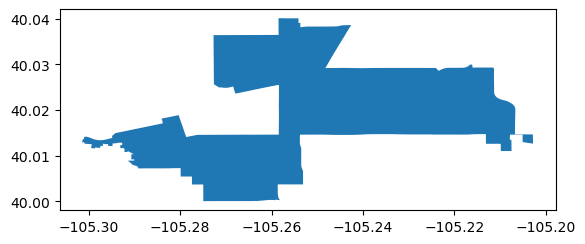

In [26]:
# create supersite boundary geometry for BHS
bhsgeom = bhsgpd.dissolve()
bhsgeom.plot()

In [ ]:

# this sets all column names and data types correctly
# area_gdf = gpd.GeoDataFrame(area_groups.get_group('BO-01').dissolve())
# area_gdf.plot()

### Create Area Boundaries
- use .dissolve() to aggregate precincts into Areas and return Area boundary geometry

In [18]:
area_groups = pctgeo.groupby('AreaShort')

In [19]:
area_groups.groups

{'BO-01': [2, 172, 173, 174, 175, 176, 182], 'BO-02': [148, 162, 163, 170, 171], 'BO-03': [160, 161, 164, 165, 168, 169], 'BO-04': [152, 153, 154, 155, 156, 157, 158, 159, 166, 167], 'BO-05': [146, 147, 149, 150, 151], 'BO-07': [140, 141, 142, 143, 144, 145], 'BO-08': [128, 135, 136, 138, 139], 'BO-09': [129, 130, 131, 133, 134], 'BO-10': [121, 122, 123, 124, 125, 126, 132], 'BO-11': [52, 53, 54, 120, 127, 137], 'ER-01': [40, 41, 42, 43, 44, 45, 46, 47, 48], 'GN-01': [55, 56, 57, 58, 59, 118, 119], 'LF-01': [23, 24, 25, 26, 27, 28, 29, 30, 31], 'LF-02': [32, 33, 34, 35, 36, 37, 38, 39, 49, 50, 51], 'LM-01': [60, 61, 62, 63, 64, 72, 73], 'LM-02': [65, 66, 67, 68, 69, 70, 71], 'LM-03': [74, 75, 76, 84, 85, 90, 91], 'LM-04': [0, 78, 79, 80, 81, 82, 95, 96, 97], 'LM-05': [83, 93, 94, 98, 99, 100, 110, 111], 'LM-06': [86, 87, 88, 89, 103, 104, 105, 106], 'LM-07': [77, 92, 101, 102, 107, 108, 109, 115, 116, 117], 'LV-01': [10, 11, 12, 13, 14, 16, 17], 'LV-02': [15, 18, 19, 20, 21, 22], 'MT-0

In [40]:
# type(area_groups.get_group('BO-01'))
area_groups.get_group('BO-01')

,Pct,Precinct,AreaShort,CD,SD,HD,geometry
2,004,2151207004,BO-01,2,15,12,"POLYGON ((-105.18469 39.96263, -105.18459 39.9..."
172,854,2184907854,BO-01,2,18,49,"POLYGON ((-105.26011 39.97808, -105.26105 39.9..."
173,855,2184907855,BO-01,2,18,49,"POLYGON ((-105.24580 39.98095, -105.24586 39.9..."
174,856,2184907856,BO-01,2,18,49,"POLYGON ((-105.24597 39.97645, -105.24597 39.9..."
175,857,2184907857,BO-01,2,18,49,"POLYGON ((-105.24748 39.96770, -105.24777 39.9..."
176,900,2154907900,BO-01,2,15,49,"MULTIPOLYGON (((-105.16920 39.92870, -105.1689..."
182,906,2154907906,BO-01,2,15,49,"POLYGON ((-105.32196 40.01455, -105.32214 40.0..."


In [18]:
# Create boundary for each Area from outline of precincts in Area
for name, group in area_groups:
    area_gdf = pd.concat([area_gdf, group.dissolve()], ignore_index=True)   

In [19]:
area_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   geometry   28 non-null     geometry
 1   Pct        28 non-null     object  
 2   Precinct   28 non-null     object  
 3   AreaShort  28 non-null     object  
 4   CD         28 non-null     object  
 5   SD         28 non-null     object  
 6   HD         28 non-null     object  
dtypes: geometry(1), object(6)
memory usage: 1.7+ KB


In [20]:
area_gdf

,geometry,Pct,Precinct,AreaShort,CD,SD,HD
0,"MULTIPOLYGON (((-105.16920 39.92870, -105.1691...",004,2151207004,BO-01,2,15,12
1,"MULTIPOLYGON (((-105.16920 39.92870, -105.1691...",004,2151207004,BO-01,2,15,12
2,"POLYGON ((-105.24761 39.98298, -105.24699 39.9...",830,2181007830,BO-02,2,18,10
3,"POLYGON ((-105.23584 39.98517, -105.23555 39.9...",842,2181007842,BO-03,2,18,10
4,"POLYGON ((-105.21283 39.98575, -105.21282 39.9...",834,2181007834,BO-04,2,18,10
5,"POLYGON ((-105.25864 40.00236, -105.25865 40.0...",828,2184907828,BO-05,2,18,49
6,"POLYGON ((-105.25838 40.01917, -105.25838 40.0...",822,2181007822,BO-07,2,18,10
7,"POLYGON ((-105.21595 40.02929, -105.21586 40.0...",810,2181007810,BO-08,2,18,10
8,"POLYGON ((-105.27269 40.03465, -105.27268 40.0...",811,2181007811,BO-09,2,18,10
9,"POLYGON ((-105.25965 40.05103, -105.25948 40.0...",803,2181007803,BO-10,2,18,10


In [21]:
# Delete duplicate 1st row
area_gdf.drop(0, inplace=True)

In [23]:
area_gdf = area_gdf[['AreaShort', 'geometry']]
area_gdf

,AreaShort,geometry
1,BO-01,"MULTIPOLYGON (((-105.16920 39.92870, -105.1691..."
2,BO-02,"POLYGON ((-105.24761 39.98298, -105.24699 39.9..."
3,BO-03,"POLYGON ((-105.23584 39.98517, -105.23555 39.9..."
4,BO-04,"POLYGON ((-105.21283 39.98575, -105.21282 39.9..."
5,BO-05,"POLYGON ((-105.25864 40.00236, -105.25865 40.0..."
6,BO-07,"POLYGON ((-105.25838 40.01917, -105.25838 40.0..."
7,BO-08,"POLYGON ((-105.21595 40.02929, -105.21586 40.0..."
8,BO-09,"POLYGON ((-105.27269 40.03465, -105.27268 40.0..."
9,BO-10,"POLYGON ((-105.25965 40.05103, -105.25948 40.0..."
10,BO-11,"POLYGON ((-105.17826 40.05174, -105.17826 40.0..."


<Axes: >

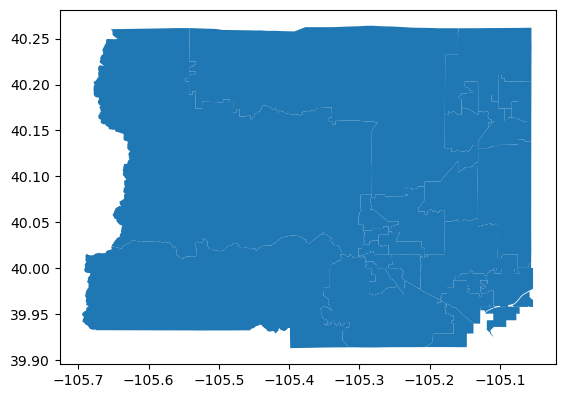

In [24]:
area_gdf.plot()

In [32]:
area_gdf.to_file('../geo/geojson/areas.geojson', driver='GeoJSON')

### test areas.geojson

In [29]:
area_test = gpd.read_file('../geo/geojson/areas.geojson', driver='GeoJSON')
area_test.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   AreaShort  27 non-null     object  
 1   geometry   27 non-null     geometry
dtypes: geometry(1), object(1)
memory usage: 560.0+ bytes


<Axes: >

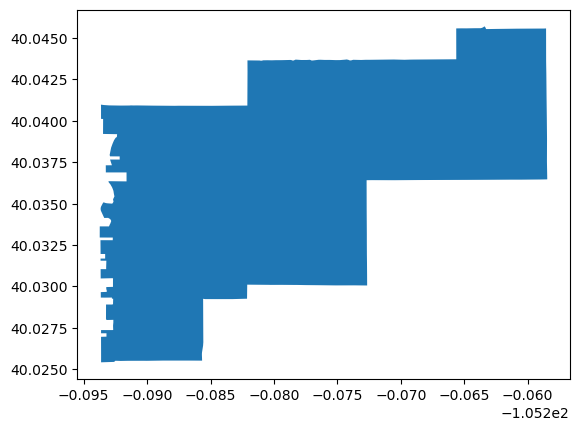

In [31]:
area_test[area_test.AreaShort == 'BO-09'].plot()

## Transform data in dataframes

## Save transformed data in map format files